In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
file_path = '/content/drive/My Drive/Colab Notebooks/Research Techniques II/train-00000-of-00001.parquet'

In [7]:
import pandas as pd

df = pd.read_parquet(file_path)
df.head()

,text,labels
0,"Tempalqin, baralqin, miqren, elm, təhsil",neutral
1,"Başa düşmürəm, mən o vaxt onlardan necə gedə b...",negative
2,Taksto fener en sonuncu para kubok qazanivaosk...,neutral
3,Halal olsun admin heyyətinə. Tək tük səhifələr...,positive
4,Dunya seyaheti etmek ucun limitsiz bilet ve pul,positive


In [8]:
df = df[df['labels'].isin(["positive", "negative"])].copy()
df['labels'] = df['labels'].map({"negative": 0, "positive": 1})

In [9]:
print(df['labels'].value_counts())

labels
0    14000
1    14000
Name: count, dtype: int64


In [10]:
import re

def basic_cleaning(text):
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # URL
    text = re.sub(r'\){2,}', '', text)                 # ))))
    text = re.sub(r'\s{2,}', ' ', text)                # Çift boşluk
    return text.strip()

df['text'] = df['text'].apply(basic_cleaning)

In [11]:
from datasets import Dataset

df = df.rename(columns={'labels': 'label'})  # Trainer için gerekli
dataset = Dataset.from_pandas(df[['text', 'label']])

In [12]:
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
df_val, df_test = train_test_split(df_temp, test_size=0.5, stratify=df_temp['label'], random_state=42)

from datasets import Dataset

dataset_train = Dataset.from_pandas(df_train[['text', 'label']])
dataset_val = Dataset.from_pandas(df_val[['text', 'label']])
dataset_test = Dataset.from_pandas(df_test[['text', 'label']])

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "distilbert-base-multilingual-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

dataset_train = dataset_train.map(tokenize_fn, batched=True)
dataset_val = dataset_val.map(tokenize_fn, batched=True)
dataset_test = dataset_test.map(tokenize_fn, batched=True)

Map:   0%|          | 0/19600 [00:00<?, ? examples/s]

Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

Map:   0%|          | 0/4200 [00:00<?, ? examples/s]

In [18]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds)
    return {
        "accuracy": acc,
        "f1": f1
    }


training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # ✅ bu doğru
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=4,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

# Dinamik padding için
data_collator = DataCollatorWithPadding(tokenizer)

# Trainer nesnesi
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

<ipython-input-18-202769f3c5c7>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [19]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.461200,0.535971,0.751429,0.721600
2,0.326800,0.530715,0.773810,0.760585
3,0.225900,0.752739,0.773333,0.774086
4,0.234800,0.973643,0.766190,0.766302


TrainOutput(global_step=4900, training_loss=0.264697509572214, metrics={'train_runtime': 905.3903, 'train_samples_per_second': 86.592, 'train_steps_per_second': 5.412, 'total_flos': 1.03854440546304e+16, 'train_loss': 0.264697509572214, 'epoch': 4.0})

In [20]:
results = trainer.predict(dataset_test)
preds = np.argmax(results.predictions, axis=1)

In [21]:
from sklearn.metrics import classification_report

print(classification_report(dataset_test["label"], preds, target_names=["negative", "positive"]))

              precision    recall  f1-score   support

    negative       0.77      0.77      0.77      2100
    positive       0.77      0.77      0.77      2100

    accuracy                           0.77      4200
   macro avg       0.77      0.77      0.77      4200
weighted avg       0.77      0.77      0.77      4200



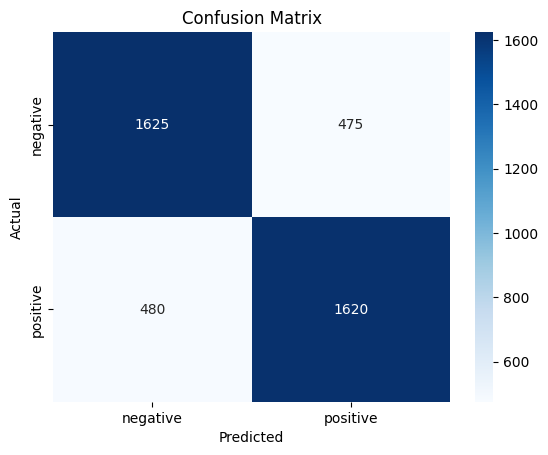

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(dataset_test["label"], preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "positive"], yticklabels=["negative", "positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()